## ONLINE RETAIL ANALYTICS - SQL&PYTHON PROJECT
-----------------------------------------------------------------
## Key Insights

High-value customers contribute disproportionate revenue

Many customers are one-time buyers

At-risk customers can be reactivated via targeted campaigns

## Business Actions

Loyalty rewards for high-value segment

Email reminders for at-risk customers

Discounts for first-time repeat purchases

In [1]:
import os
os.listdir()

['.ipynb_checkpoints',
 'code.ipynb',
 'online_retail.db',
 'online_retail_.csv',
 'onlline_retail_analysis.sql']

In [2]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("online_retail.db")

# Load CSV
df_raw = pd.read_csv("online_retail_.csv", encoding="ISO-8859-1")

# Save to SQLite
df_raw.to_sql("online_retail", conn, if_exists="replace", index=False)

print(" online_retail table created")

 online_retail table created


In [3]:
pd.read_sql("""
SELECT name 
FROM sqlite_master 
WHERE type='table';
""", conn)

,name
0,online_retail_clean
1,online_retail


In [4]:
print(df_raw.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')


In [ ]:
conn.execute("""
CREATE TABLE online_retail_clean AS
SELECT *
FROM online_retail
WHERE
    CustomerID IS NOT NULL
    AND Quantity > 0
    AND Price > 0
    AND Invoice NOT LIKE 'C%';
""")

conn.commit()

In [6]:
pd.read_sql("""
SELECT name 
FROM sqlite_master 
WHERE type='table';
""", conn)

,name
0,online_retail_clean
1,online_retail


In [7]:
df = pd.read_sql("SELECT * FROM online_retail_clean", conn)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
# PHASE 6: EDA (Exploratory Data Analysis)

print(df.shape)
df.isna().sum()

(397885, 8)


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

In [9]:
#Feature Engineering (Analytics Columns)
print(df['InvoiceDate'].dtype)
df['InvoiceDate'].head(10)

object


0    01-12-2010 08:26
1    01-12-2010 08:26
2    01-12-2010 08:26
3    01-12-2010 08:26
4    01-12-2010 08:26
5    01-12-2010 08:26
6    01-12-2010 08:26
7    01-12-2010 08:28
8    01-12-2010 08:28
9    01-12-2010 08:34
Name: InvoiceDate, dtype: object

In [10]:
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)

In [11]:
df['InvoiceDate'].isna().sum()

np.int64(0)

In [12]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create Revenue
df['Revenue'] = df['Quantity'] * df['Price']

# Create Month column
df['Month'] = df['InvoiceDate'].dt.to_period('M')

df[['InvoiceDate', 'Revenue', 'Month']].head()

,InvoiceDate,Revenue,Month
0,2010-12-01 08:26:00,15.30,2010-12
1,2010-12-01 08:26:00,20.34,2010-12
2,2010-12-01 08:26:00,22.00,2010-12
3,2010-12-01 08:26:00,20.34,2010-12
4,2010-12-01 08:26:00,20.34,2010-12


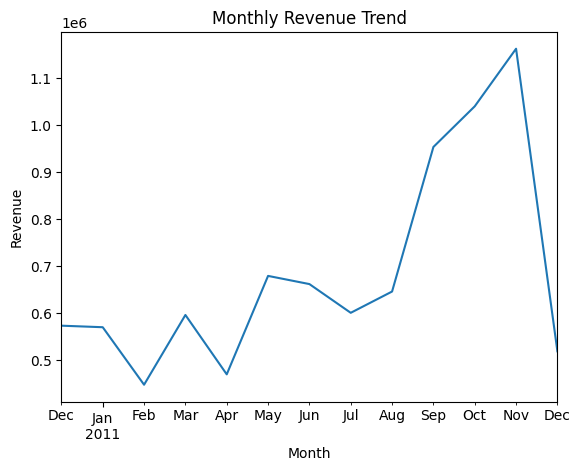

In [55]:
monthly_revenue = df.groupby('Month')['Revenue'].sum()

plt.figure()
monthly_revenue.plot()
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

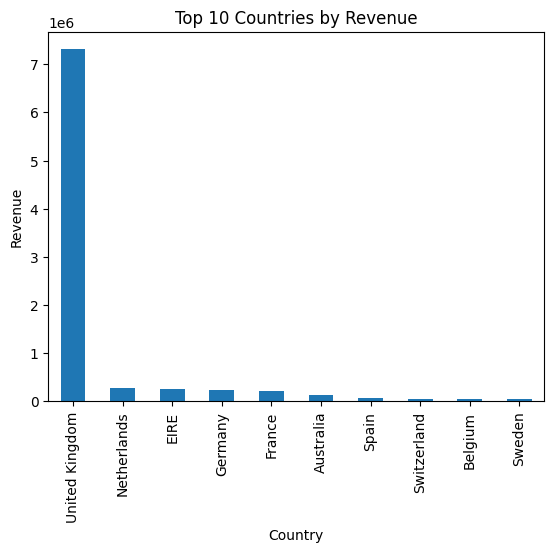

In [56]:
top_countries = (
    df.groupby('Country')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.show()

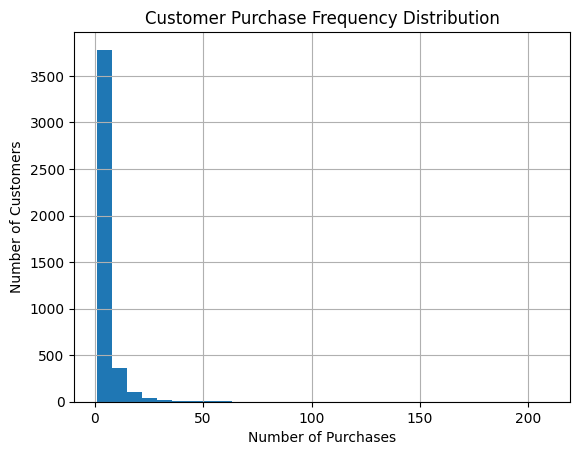

In [58]:
customer_freq = df.groupby('CustomerID')['Invoice'].nunique()

plt.figure()
customer_freq.hist(bins=30)
plt.title("Customer Purchase Frequency Distribution")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

In [60]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Revenue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


In [62]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.055178
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [63]:
cluster_labels = {
    0: "High Value",
    1: "Loyal",
    2: "At Risk",
    3: "Low Value"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

rfm[['Recency', 'Frequency', 'Monetary', 'Segment']].head()

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12346.0,326,1,77183.60,Low Value
12347.0,2,7,4310.00,High Value
12348.0,75,4,1797.24,High Value
12349.0,19,1,1757.55,High Value
12350.0,310,1,334.40,Loyal
